<img src="https://raw.githubusercontent.com/sobester/ADRpy/master/docs/ADRpy/ADRpy_splash.png" width="40%" align="left">

# ADRpy models - Engine Decks

> _"Wait until we have worked on it for a while; we will soon design the simplicity out of it!"_ Lord Hives (of Rolls Royce) remark to Whittle's explanation of the simplicity of the jet engine <cite data-cite="Not Much of an Engineer">(Hooker, 1984)

An engine deck is a computerised model of an engine. The engine deck class takes real data from various engines where it has been digitised and converted into standardised forms. Manufactures of modern engines tend not to share information about their engines and so the data used tends to be from older aero engines. Despite this a good range of data for engines of different sizes is available. Note that in the conversion process some additional data specific to a particular source is lost.

The data used takes the form of performance curves. These have then been digitised and then interpolation is used to estimate data between the curves. They show some of the key aspects of an engines performance for aeronautical applications.

There are ways to model the performance of a jet engine, however the real world is much more complex and nuanced than the simple models that try and capture it. Various discrepancies resulting from the complexities and operational details of the engines can result in significant deviations from theory. This data, it allows us to get more of a handle on the performance of these engines. We can use this data to see how the actual engine's performance will affect the design choices made in aeronautical engineers.

While this data is a step up from simple theories and assumptions, it still doesn't capture all the nuances of the engine's performance for all the operating conditions. For example, engine age, fuel type and inlet temperature are not directly accounted for. These engine decks are only as sophisticated as the data used to create them.

## <span style="color:teal">dict</span> `engine_catalogue`

We begin by producing a list of propulsion systems available to a user.

In [1]:
import json
from ADRpy.propulsion import engine_catalogue

# From the engine catalogue, record each available engine along with its "type" classification
custom_map = {k: v["type"] for (k, v) in engine_catalogue.items()}

print(json.dumps(custom_map, indent=2))

{
  "JM-X57": "electric",
  "YASA-750R": "electric",
  "IO-540": "piston",
  "Wasp Major B13": "piston",
  "ATF3-6A": "turbofan",
  "F404-400": "turbofan",
  "FJ44": "turbofan",
  "JT8D-9": "turbofan",
  "JT9D-3": "turbofan",
  "TF30": "turbofan",
  "TFE731-2": "turbofan",
  "TFE731-5": "turbofan",
  "J52": "turbojet",
  "J60": "turbojet",
  "T56-A": "turboprop",
  "Tyne RTy.11": "turboprop"
}


## <span style="color:blue">class</span> `EngineDeck`:

The `EngineDeck` class is the main star of ADRpy's propulsion module.
Here we will demonstrate the capability and use of the 'JT9D-3' engine deck.

In [2]:
from ADRpy.propulsion import EngineDeck

# Instantiate using the name as it appears in the engine_catalogue
deck = EngineDeck("JT9D-3")

The Pratt & Whitney JT9D-3 is a high bypass ratio turbofan which first saw service with the Boeing 747-100.
In ADRpy, we can map out an engine's thrust performance given flight conditions (in ISA conditions).

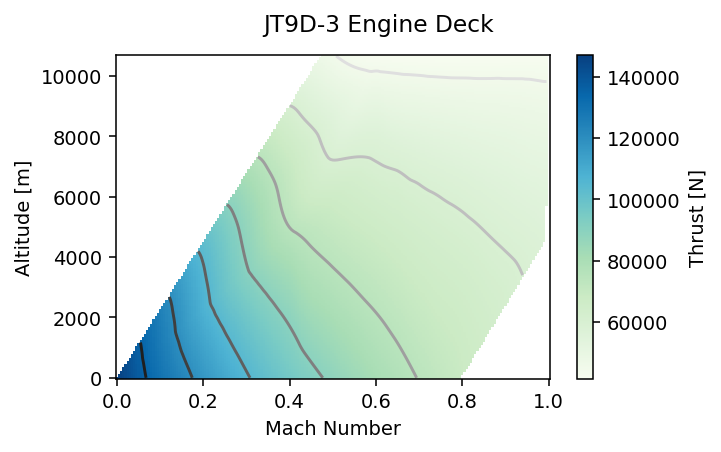

In [3]:
from matplotlib import pyplot as plt
import numpy as np
from ADRpy.unitconversions import feet2m

# Generate plot data
machs = np.linspace(0, 1, 201)
altitudes = np.linspace(0, feet2m(35e3), 201)

X, Y = np.meshgrid(machs, altitudes)
Z = deck.thrust(X, Y)

# Make a plot with a 2D "heat map"
fig, ax = plt.subplots(dpi=140, figsize=(5, 3))
im = ax.pcolormesh(X, Y, Z, cmap="GnBu")
ax.contour(X, Y, Z, cmap="binary")

# Plot labels
fig.suptitle(f"{deck.name} Engine Deck")
fig.colorbar(im, ax=ax, label="Thrust [N]")
ax.set_xlabel("Mach Number")
ax.set_ylabel("Altitude [m]")

plt.show()

Engine performance is often dependent on external conditions such as freestream velocity, ambient temperature, and ambient pressure.
Combinations of these parameters often lead to a "lapse" in the engine's available thrust (or shaftpower) - which are simply computed by normalising the output with the sea-level static performance.

In [4]:
mach0_0 = deck.thrust(mach=0.0, altitude=0, norm=True)
mach0_4 = deck.thrust(mach=0.4, altitude=0, norm=True)

print(f"At sea-level/rest, the {deck.name} produces {float(mach0_0):.0%} of its sea-level static thrust.")
print(f"At sea-level/M=0.4, the {deck.name} produces {float(mach0_4):.0%} of its sea-level static thrust.")

At sea-level/rest, the JT9D-3 produces 100% of its sea-level static thrust.
At sea-level/M=0.4, the JT9D-3 produces 65% of its sea-level static thrust.


At the time of service, some engines made use of water injection to augment thrust during particularly demanding conditions (such as takeoff).
Let's compare the thrust available to the engine at takeoff, with and without water injection.

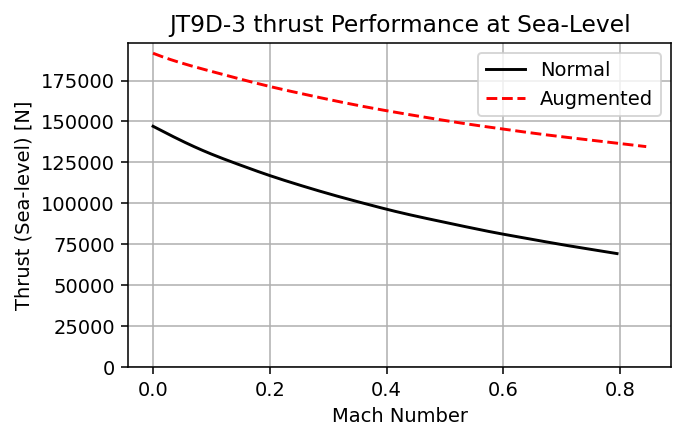

In [5]:
thrust_standard = deck.thrust(mach=machs, altitude=0)
thrust_slto = deck.thrust_slto(mach=machs)

fig, ax = plt.subplots(dpi=140, figsize=(5, 3))

ax.plot(machs, thrust_standard, label="Normal", c="k")
ax.plot(machs, thrust_slto, label="Augmented", c="r", ls="--")

ax.set_title(f"{deck.name} thrust Performance at Sea-Level")
ax.set_xlabel("Mach Number")
ax.set_ylabel("Thrust (Sea-level) [N]")
ax.set_ylim(0, None)
ax.legend()
ax.grid()
plt.show()

Now lets look at an engine that does not contain a thrust augmentation system: the Tyne RTy.11.

In [6]:
deck2 = EngineDeck("Tyne RTy.11")
print(f"The {deck2.name} is a {deck2.type} engine.")

The Tyne RTy.11 is a turboprop engine.


The data provided for this engine includes the thrust from the turboprop core and the power developed by the turboshaft - but no data on the fan (cold) thrust.
In such a case, ADRpy uses a simplistic propeller efficiency model from J.D.Mattingly.

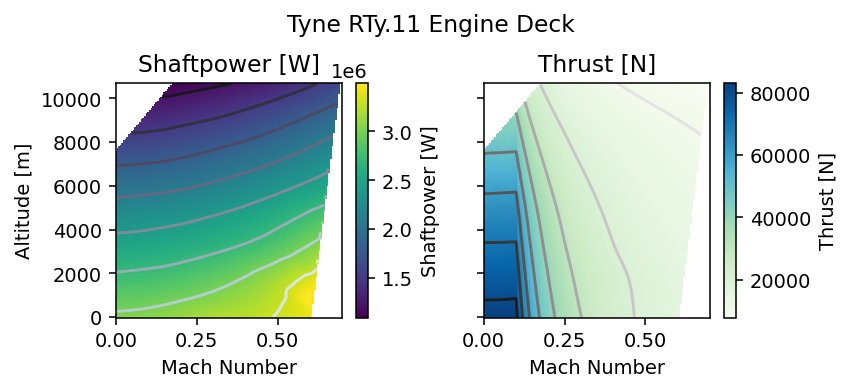

In [7]:
X, Y = np.meshgrid(machs, altitudes)
Z0 = deck2._f_shaftpower(X, Y)
Z1 = deck2.thrust(X, Y)

# Make a plot with a 2D "heat map"
fig, axs = plt.subplots(1, 2, dpi=140, figsize=(6, 2.5), sharex=True, sharey=True)

im0 = axs[0].pcolormesh(X, Y, Z0, cmap="viridis")
axs[0].contour(X, Y, Z0, cmap="bone")
im1 = axs[1].pcolormesh(X, Y, Z1, cmap="GnBu")
axs[1].contour(X, Y, Z1, cmap="binary")

# Plot labels
fig.suptitle(f"{deck2.name} Engine Deck")
fig.subplots_adjust(top=0.78, wspace=0.3)
fig.colorbar(im0, ax=axs[0], label="Shaftpower [W]")
fig.colorbar(im1, ax=axs[1], label="Thrust [N]")
axs[0].set_title("Shaftpower [W]")
axs[0].set_ylabel("Altitude [m]")
axs[1].set_title("Thrust [N]")
for ax in axs.flat:
    ax.set_xlabel("Mach Number")
    ax.set_xlim(0, 0.7)

plt.show()

We may choose to plot thrust against sea-level takeoff thrust as we did with the JT9D-3, however, since there is no thrust augmentation - there is no effect on the developed thrust when the method is called.

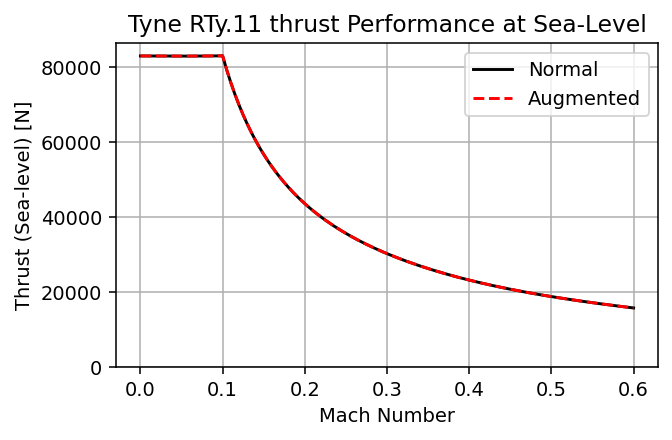

In [8]:
thrust_standard = deck2.thrust(mach=machs, altitude=0)
thrust_slto = deck2.thrust_slto(mach=machs)

fig, ax = plt.subplots(dpi=140, figsize=(5, 3))

ax.plot(machs, thrust_standard, label="Normal", c="k")
ax.plot(machs, thrust_slto, label="Augmented", c="r", ls="--")

ax.set_title(f"{deck2.name} thrust Performance at Sea-Level")
ax.set_xlabel("Mach Number")
ax.set_ylabel("Thrust (Sea-level) [N]")
ax.set_ylim(0, None)
ax.legend()
ax.grid()
plt.show()